# Project - Airline AI Assistant

**We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline.**

**We will tell the customer support agent that we are going to paris and it will come back with tcket prices to paris.**

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

# As an alternative, if you'd like to use Ollama instead of OpenAI
# Check that Ollama is running for you locally (see week1/day2 exercise) then uncomment these next 2 lines
# MODEL = "llama3.2"
# openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')


OpenAI API Key exists and begins sk-proj-




**Below is our system message and note how we have added that if you don't know the answer , say so. This way we can reduce hallucination by the model**

In [6]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [7]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## Result-
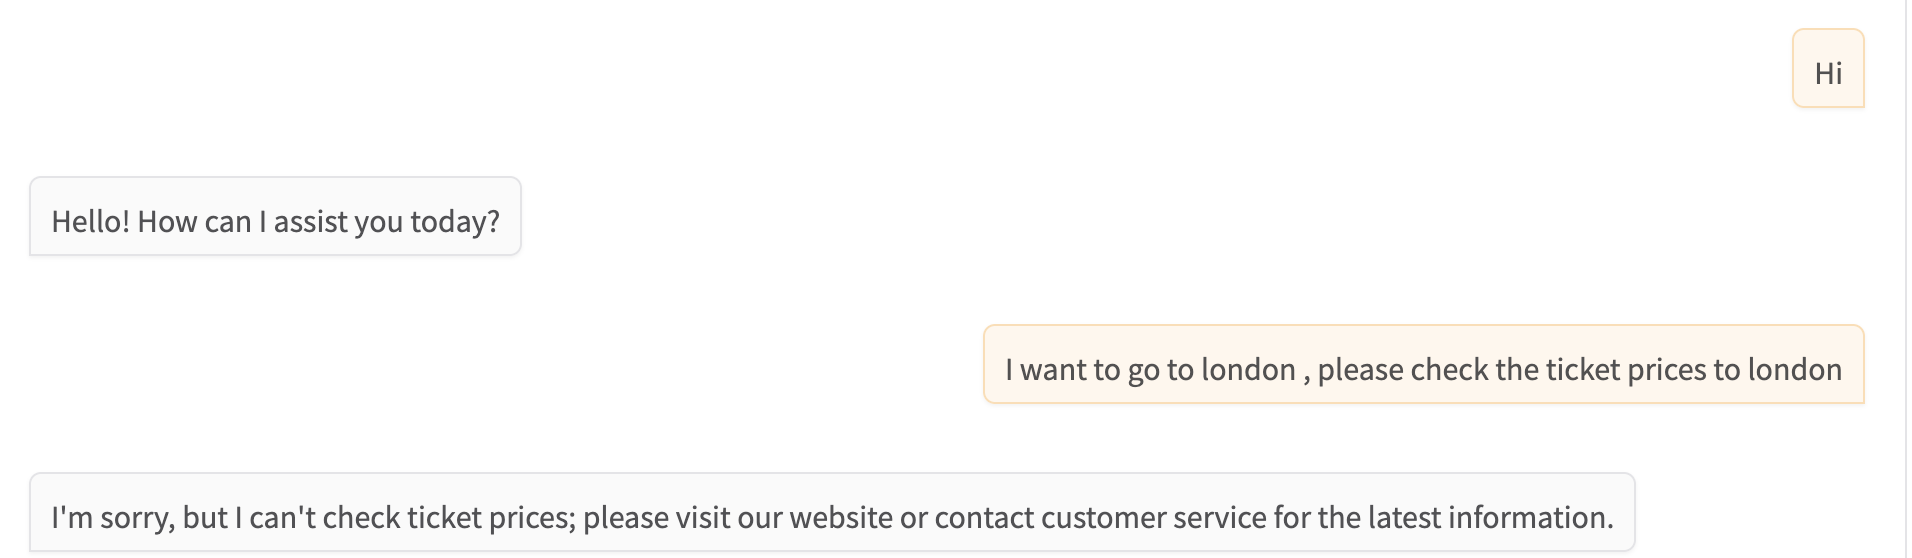

### As we can see here since we asked the model to not provide a price if it does not know , it did not return a price. This way we can reduce hallucination.


## Lets see the hallucination without the above line in the system prompt -
```
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
```
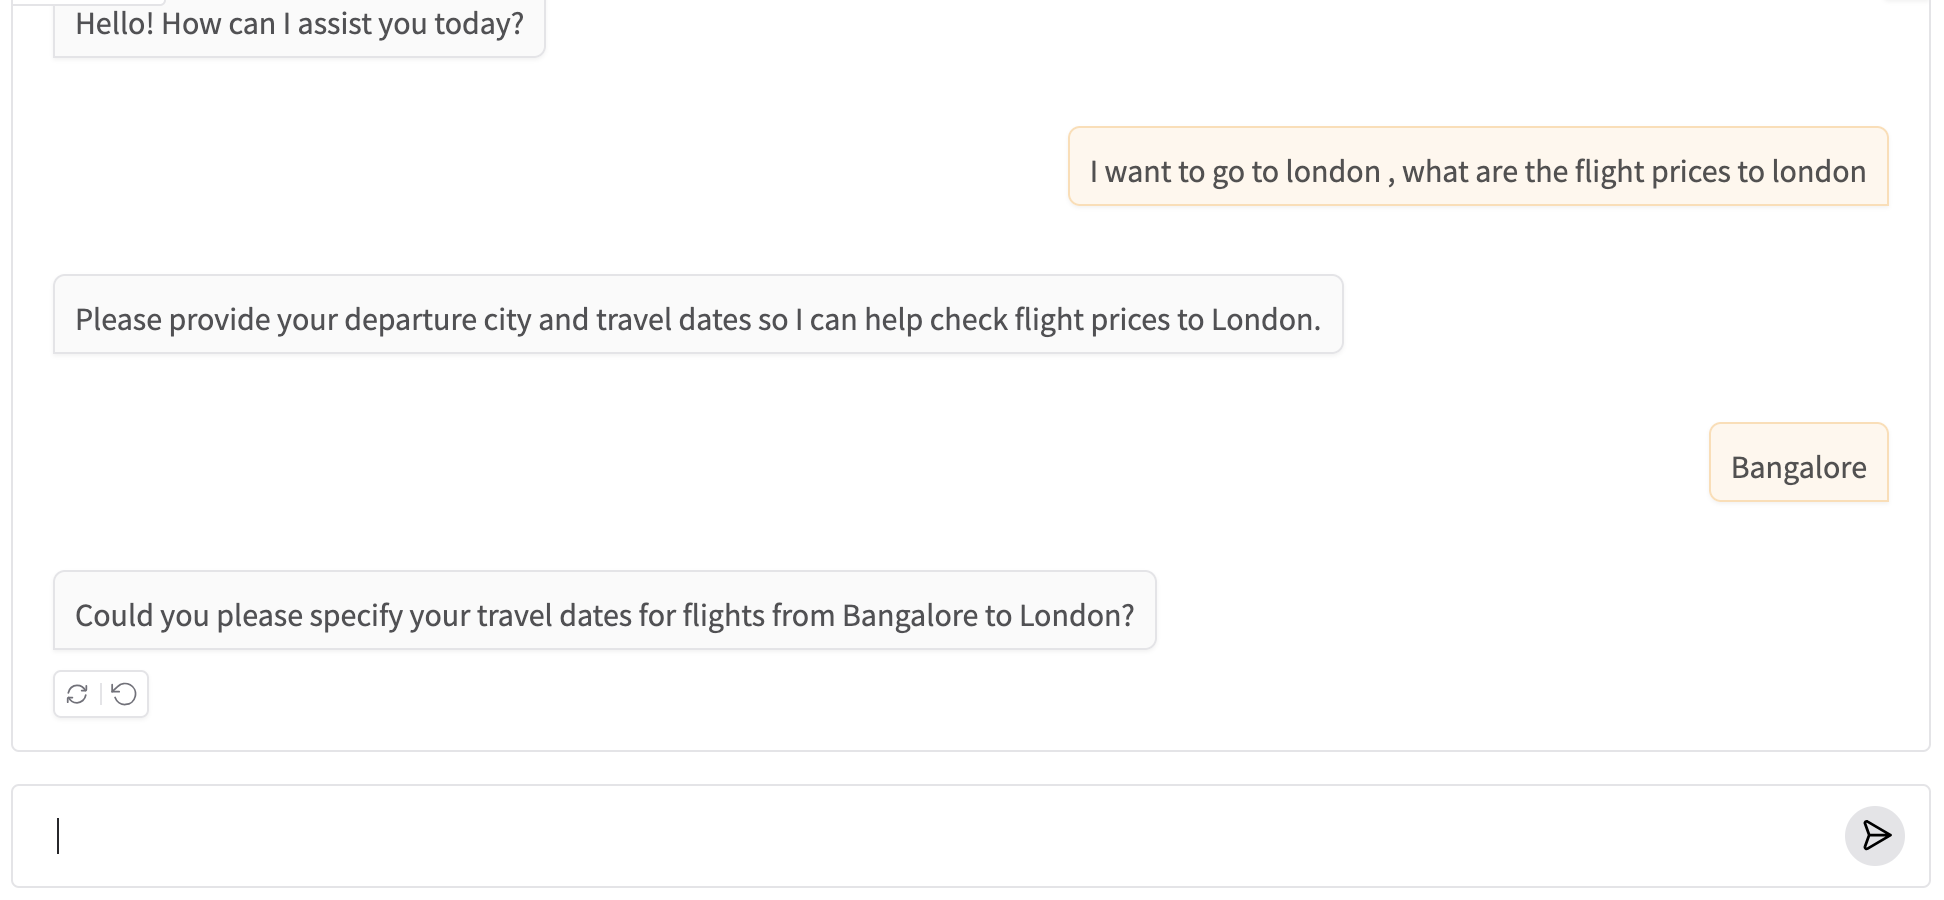

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [11]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [12]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [13]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [14]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [36]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    print("response from 1st LLM call is :")
    print(response)
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        print("message is :")
        print(message)
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        print("Updated Prompt is")
        print(messages)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

# How does this work ?

## But But, the LLM will not call the function directly . It will only inform us that it wants to call the function.
## This happen when the finish_reason is set to "tool_calls" in the response. 

This means , that Basically GPT will say , i do not have a output for you yet , instead , you run this tool and provide me the output of the tool and 
then i will give you the final output.

So if GPT wants us to run the tool -
```if response.choices[0].finish_reason=="tool_calls":```

So as part of asking us to run the tool, GPT will return a message that we will have to read. We read this message-
```message = response.choices[0].message```

We need to unpack the message to understand what GPT wants us to do. 
handle_tool_call(message) is a function that we will write to handle this message.
```response, city = handle_tool_call(message)```

Then we add the last response from the llm into the messages list so that we can continue the conversation by linking the last message.
```messages.append(message)```

We also add the response we got the tool call
```messages.append(response)```


Finally we call the LLM again.
Note - In the second LLm call we do not pass the tools parameter again because we do not expect the tools to be needed again

In [34]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    print("Tool Call")
    print(tool_call)
    arguments = json.loads(tool_call.function.arguments)
    print(arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    print("Response Object created")
    print(response)
    return response, city

## This is how the handle_tool_call works -

1. It is called with the message that we got from the gpt api call.
2. Then we need to **unpack the tool** from the tool details returned by the LLM response.
   1. First we find out which tool the llm wants us to call.
           ```tool_call = message.tool_calls[0]```
   2. Then we get the arguments for this function from the dictionary of the tool we created .
    Note - here we are loading the json and getting the tool_call that the llm needs but in this case since we have only one tool so we know which      tool has be invoked
   3. We get the parameter destination from the tool call json.
   4. With this the unpacking of the tool is complete.

3. Then we need to call the tool or function by passing the destination argument we retrieved from the llm response message.
   
5. Then we create a response for the tool , just like we created for system , user and assistant.
   1. The role is tool
   2. The content is destination city and the price in a dictionary turned into a json.
   3. Lastly , we also need to add the tool_call id.

In [37]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


response from 1st LLM call is :
ChatCompletion(id='chatcmpl-BqcFitYapTcfCwqN7HxISWu41rHCV', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1751879798, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_34a54ae93c', usage=CompletionUsage(completion_tokens=10, prompt_tokens=116, total_tokens=126, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
response from 1st LLM call is :
ChatCompletion(id='chatcmpl-BqcFqdNzPzEYDPXxsDnGsL0YTRtwl', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Great choice! How can I help you w

# Lets see a sample Result -

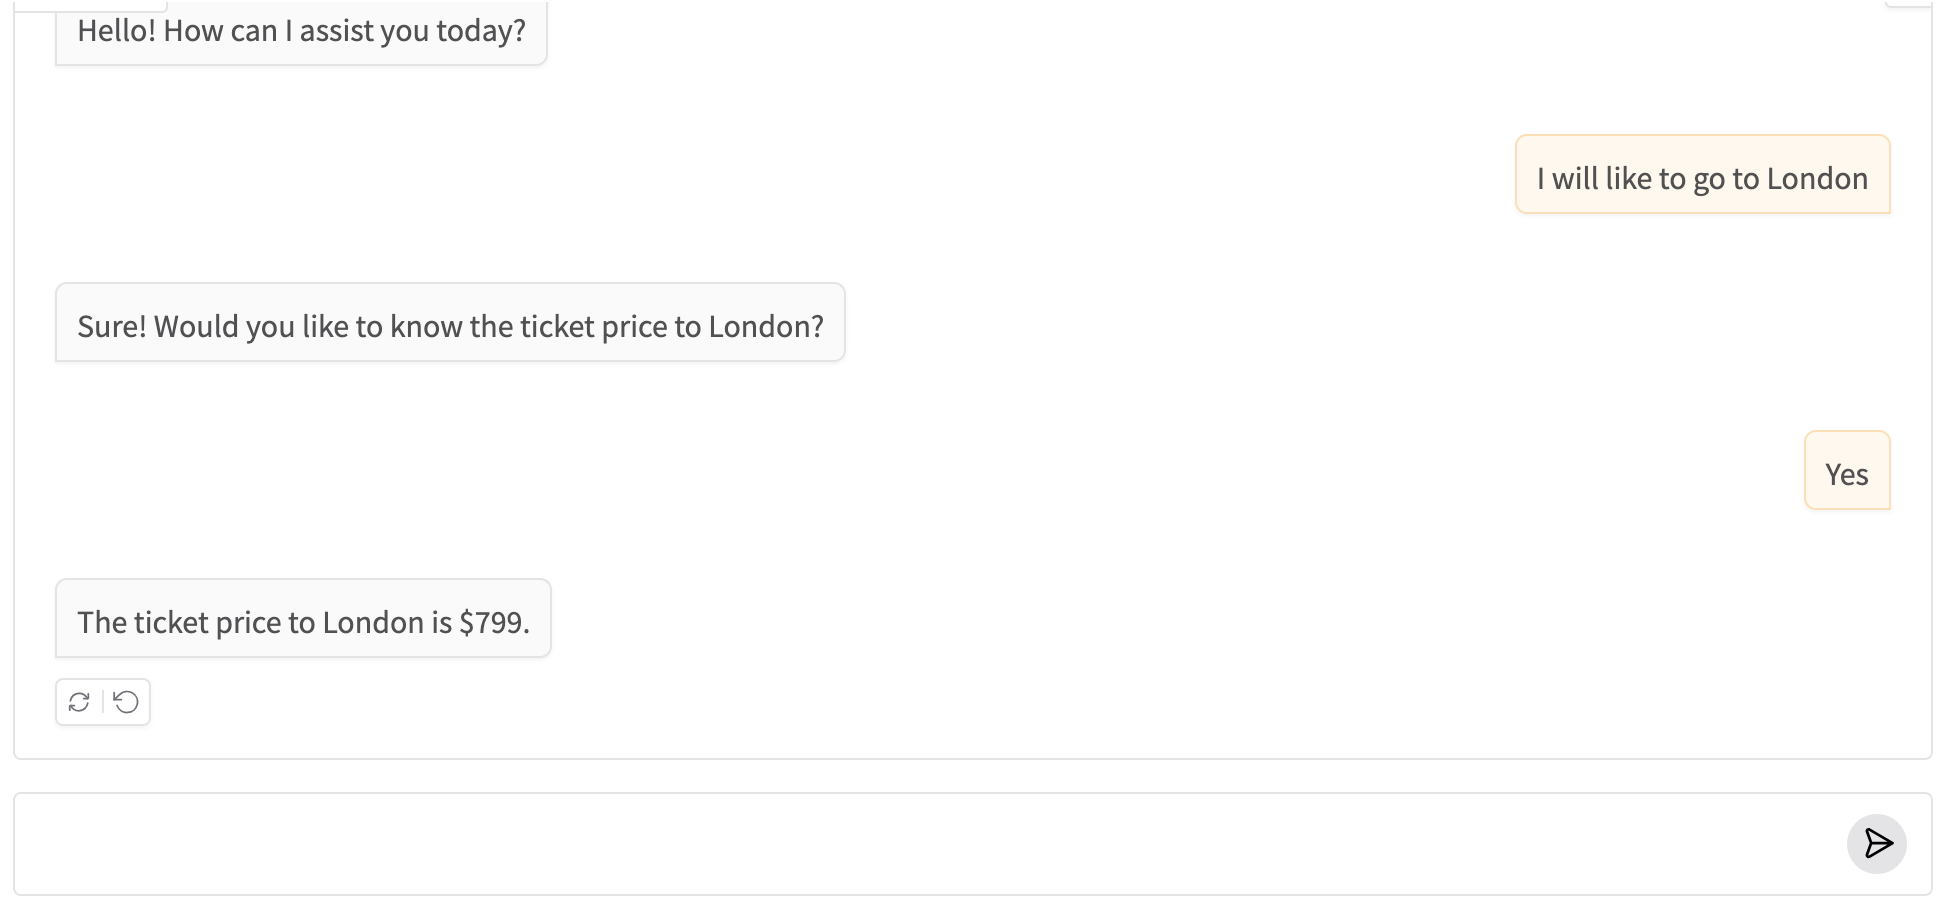

Lets see the sequence of events-

1. user types Hi , gpt is called and it responds

   ```
   ChatCompletion(id='chatcmpl-BqbzxnINZXZoYoxa3VeubqPXHWLLs', choices=[Choice(finish_reason='stop', index=0, logprobs=None,    message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1751878821, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_34a54ae93c', usage=CompletionUsage(completion_tokens=10, prompt_tokens=117, total_tokens=127, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
   
   ```

2. Then user types - I will like to go to London , and then again user responds Yes . At this point , gpt responds that a tool call is needed
```
ChatCompletion(id='chatcmpl-Bqc063dR07dXIKrbnC6XeNX19IxVI', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_tDmvvHp5ZNK9o60PNgw9Ajhr', function=Function(arguments='{"destination_city":"London"}', name='get_ticket_price'), type='function')]))], created=1751878830, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_34a54ae93c', usage=CompletionUsage(completion_tokens=16, prompt_tokens=163, total_tokens=179, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
```

**As we can see above the finish_reason=tool_calls**
Therefore this condition is now true - ```if response.choices[0].finish_reason=="tool_calls":```

3. Now message from this response is fetched ```message = response.choices[0].message```
message is -
```
ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_tDmvvHp5ZNK9o60PNgw9Ajhr', function=Function(arguments='{"destination_city":"London"}', name='get_ticket_price'), type='function')])
``` 

4. Then the handle_tool_call function is invoked to unpack the response.
   ```response, city = handle_tool_call(message)```


**handle_tool_call()**
5. In this function , first the tool_call is fetched
```tool_call = message.tool_calls[0]```

```
tool_call =
ChatCompletionMessageToolCall(id='call_tDmvvHp5ZNK9o60PNgw9Ajhr', function=Function(arguments='{"destination_city":"London"}', name='get_ticket_price'), type='function')
```

6. Then the argument from the tool call is fetched -
   ```arguments = json.loads(tool_call.function.arguments)```

```arguments = arguments='{"destination_city":"London"}'   ```

7. Then we fetch the actual parameter of the tool or function i.e. destination city from this argument.
   "destination_city" = "London"

8. At this point the actual function will be called with the argument as London
```price = get_ticket_price(city)```


9. Once output is returned from our function , the response Object is created -
    ```    
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    ```

```{'role': 'tool', 'content': '{"destination_city": "London", "price": "$799"}', 'tool_call_id': 'call_tDmvvHp5ZNK9o60PNgw9Ajhr'}```



**chat()**
10. Comes back to the chat method , appends the message from last api call and the response object that we created by calling the tool into the prompt.
        messages.append(message)
        messages.append(response)

New Updated Prompt -
```
[
{'role': 'system', 'content': 'You are a helpful assistant for an Airline called FlightAI. Give short, courteous answers, no more than 1 sentence. '}, 

{'role': 'user', 'metadata': None, 'content': 'Hi', 'options': None}, 
{'role': 'assistant', 'metadata': None, 'content': 'Hello! How can I assist you today?', 'options': None}, 
{'role': 'user', 'metadata': None, 'content': 'will like to go to London', 'options': None}, 

{'role': 'assistant', 'metadata': None, 'content': 'Great choice! How can I help you with your trip to London? Would you like to know the ticket price?', 'options': None}, 

{'role': 'user', 'content': 'Yes'}, 

ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_82bIvw6yIiDeJ7O46QTROyMY', function=Function(arguments='{"destination_city":"London"}', name='get_ticket_price'), type='function')]), 

{'role': 'tool', 'content': '{"destination_city": "London", "price": "$799"}', 'tool_call_id': 'call_82bIvw6yIiDeJ7O46QTROyMY'}]
```

11. Then again , the llm is called and this time without the tool